In [1]:
import pandas as pd

# For computer vision, I am using torchvision
"""
torchvision.datasets
torchvision.models
torch.utils.data.Dataset
torch.utils.data.DataLoader
"""

'\ntorchvision.datasets\ntorchvision.models\ntorch.utils.data.Dataset\ntorch.utils.data.DataLoader\n'

In [2]:
import torch
from torch import nn    # neural network
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__

('2.0.1+cpu', '0.15.2+cpu')

In [3]:
# Getting a dataset ( FashionMNIST)

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(), target_transform=None)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [6]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#Converting classes to dictionary

train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
image, label = train_data[0]

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [9]:
classes = train_data.classes

classes[label]

'Ankle boot'

Image shape : torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

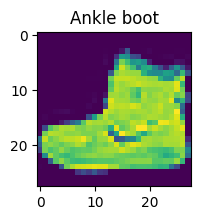

In [10]:
image, label = train_data[0]
print(f"Image shape : {image.shape}")
plt.figure(figsize=(3,2))
plt.imshow(image.permute(1,2,0))
plt.title(classes[label])

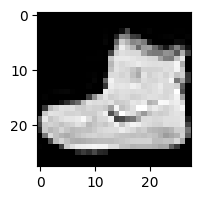

In [11]:
plt.figure(figsize=(3,2))
plt.imshow(image.permute(1,2,0), cmap='gray')

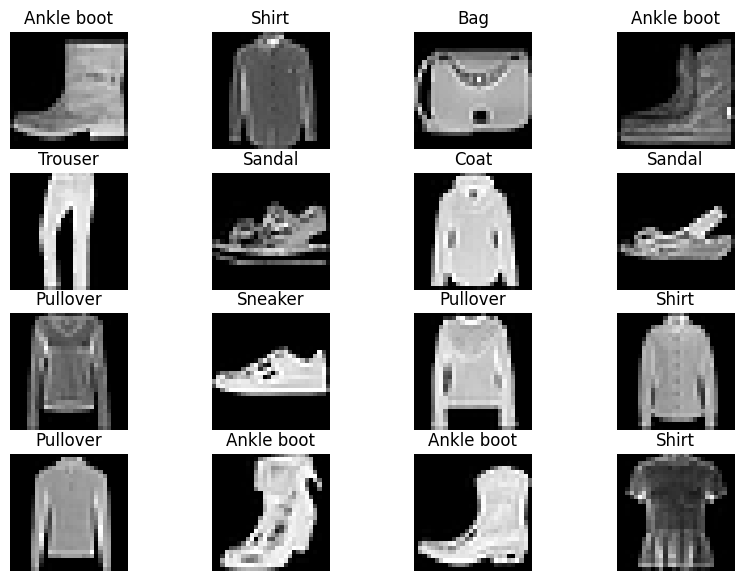

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10,7))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.title(classes[label])
    plt.axis(False)

In [13]:
# Preparing DataLoader

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x209ad84cf10>,
 <torch.utils.data.dataloader.DataLoader at 0x209ad899bd0>)

In [14]:
print(f"Dataloaders : {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader : {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader : {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x00000209AD84CF10>, <torch.utils.data.dataloader.DataLoader object at 0x00000209AD899BD0>)
Length of train_dataloader : 1875 batches of 32
Length of test_dataloader : 313 batches of 32


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [16]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape

torch.Size([32, 1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

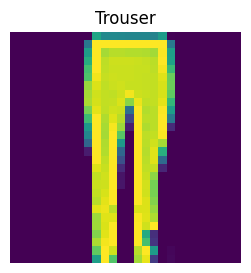

In [17]:
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.figure(figsize=(5,3))
plt.imshow(img.squeeze())
plt.title(classes[label])
plt.axis(False)

In [18]:
# Creating a baseline model

flatten_model = nn.Flatten()

x = train_features_batch[0]
# x.shape = torch.Size([1, 28, 28])

output = flatten_model(x)

output.shape

torch.Size([1, 784])

In [19]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape : int, hidden_units : int, output_shape : int):
        super().__init__()
        self.layerStack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.layerStack(x)

In [20]:
torch.manual_seed(42)

modelv0 = FashionMNISTModel(input_shape=784,hidden_units=10, output_shape=len(classes))

modelv0

FashionMNISTModel(
  (layerStack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
# passing a dummy sample

dummy_x = torch.rand([1,1,28,28])

modelv0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [22]:
# Setting up loss function and optimizer

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=modelv0.parameters(), lr = 0.03)

In [23]:
# Setting up a timer function
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device:torch.device=None):
    total_time = end-start
    print(f"Train time  : { total_time:.3f} seconds")
    return total_time

In [24]:
# Testing the timer function
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time)

Train time  : 0.000 seconds


3.0199997127056122e-05

In [25]:
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 10

train_time_start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}")
    train_loss = 0
    for batch, (img,label) in enumerate(train_dataloader):
        modelv0.train()
        train_preds = modelv0(img)
        loss = loss_fn(train_preds, label)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(img)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)
    test_loss = 0
    test_acc = 0
    modelv0.eval()
    with torch.inference_mode():
        for img, label in test_dataloader:
            test_pred = modelv0(img)
            test_loss += loss_fn(test_pred, label)

            test_acc += accuracy_fn(y_true=label, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        print(f"Train loss : {train_loss:.4f}, test loss {test_loss:4f}, test_acc : {test_acc:.4f}")
train_time_end = timer()

total_train_time_modelv0 = print_train_time(start=train_time_start, end=train_time_end)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.6746, test loss 0.520926, test_acc : 81.7093
Epoch : 1
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4842, test loss 0.482144, test_acc : 83.0771
Epoch : 2
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4559, test loss 0.470597, test_acc : 83.4864
Epoch : 3
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4406, test loss 0.460116, test_acc : 83.7360
Epoch : 4
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/6

In [26]:
torch.manual_seed(42)
def eval_model(model : torch.nn.Module, data_loader : torch.utils.data.DataLoader, loss_fn : torch.nn.Module, accuracy_fn):
    loss, acc = 0, 0
    modelv0.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            test_pred = model(X)
            loss += loss_fn(test_pred, y)
            acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model" : model.__class__.__name__,
            "loss" : loss.item(),
            "acc" : acc
            }

modelv0_results = eval_model(model=modelv0, data_loader=test_dataloader,loss_fn=loss_fn, accuracy_fn=accuracy_fn)


modelv0_results

{'model': 'FashionMNISTModel',
 'loss': 0.45277267694473267,
 'acc': 84.06549520766774}

In [27]:
## Setting up device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
# Another model to improve the performance

class FashionMNISTModel1(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [29]:
modelv1 = FashionMNISTModel1(input_shape=784, output_shape=len(classes), hidden_units=10).to(device)

modelv1

FashionMNISTModel1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [30]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv1.parameters(), lr = 0.1)

In [31]:
# Setting up training step function

def train_step(model : torch.nn.Module, data_loader : torch.utils.data.DataLoader, loss_fn : torch.nn.Module, optimizer : torch.optim.Optimizer, accuracy_fn, device : torch.device = device):

    train_loss = 0
    acc = 0
    model.train()
    for batch, (img,label) in enumerate(data_loader):
        train_preds = model(img)
        loss = loss_fn(train_preds, label)
        train_loss+=loss
        acc+= accuracy_fn(y_true=label, y_pred=train_preds.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(img)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(data_loader)
    acc /= len(data_loader)

    print(f"Train loss : {train_loss:.4f}, train acc : {acc:2f}%")

In [32]:
# Setting up a function for testing loop
def test_step(model : torch.nn.Module, data_loader : torch.utils.data.DataLoader, loss_fn : torch.nn.Module, accuracy_fn, device : torch.device = device):

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:
            test_preds = model(x)
            test_loss += loss_fn(test_preds, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_preds.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss : {test_loss:.3f}, test acc : {test_acc:.2f}%")


In [33]:
# Training and testing loop


from timeit import default_timer as timer

train_time_start = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}")

    train_step(model=modelv1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)

    test_step(model=modelv1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

train_time_end = timer()

total_train_time_modelv1 = print_train_time(start=train_time_start, end=train_time_end)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.6809, train acc : 75.285000%
Test loss : 0.508, test acc : 81.62%
Epoch : 1
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4804, train acc : 82.630000%
Test loss : 0.499, test acc : 82.25%
Epoch : 2
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4414, train acc : 84.003333%
Test loss : 0.457, test acc : 83.81%
Epoch : 3
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.4227, train acc : 84.705000%
Test loss : 0.474, test acc : 82.90%
Epoch : 4
Looked at 0/60000 samp

In [34]:
modelv0_results, total_train_time_modelv0

({'model': 'FashionMNISTModel',
  'loss': 0.45277267694473267,
  'acc': 84.06549520766774},
 97.69706580042839)

In [35]:
modelv1_results = eval_model(model=modelv1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

modelv1_results, total_train_time_modelv1

({'model': 'FashionMNISTModel1',
  'loss': 0.42878568172454834,
  'acc': 84.564696485623},
 98.83056169981137)

In [36]:
# Building a Convolutional neural network

class FashionMNISTModelv2(nn.Module):
    def __init__(self, input_shape: int, hidden_untis : int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_untis, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_untis, out_channels=hidden_untis, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_untis, out_channels=hidden_untis, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_untis, out_channels=hidden_untis, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_untis*7*7, out_features=output_shape)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor :
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [37]:
image.shape

torch.Size([1, 28, 28])

In [38]:
torch.manual_seed(42)

modelv2 = FashionMNISTModelv2(input_shape=1, hidden_untis=10, output_shape=len(classes)).to(device)

In [39]:
# Testing

torch.manual_seed(42)

images = torch.randn(size=(32,3,64,64))

test_image = images[0]

images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [40]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

In [41]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_conv = conv_layer(test_image)
print(test_image_conv.shape)

test_image_pool = max_pool_layer(test_image_conv)
print(test_image_pool.shape)

torch.Size([10, 64, 64])
torch.Size([10, 32, 32])


In [42]:
# Creating a random tensor

random_tensor = torch.randn(size=(1,1,2,2))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
random_tensor_output = max_pool_layer(random_tensor)

print(random_tensor)
random_tensor_output.shape, random_tensor_output

tensor([[[[0.4963, 0.0045],
          [0.5534, 0.1379]]]])


(torch.Size([1, 1, 1, 1]), tensor([[[[0.5534]]]]))

In [43]:
# Testing model with dummy tensor

dummy_tensor = torch.randn(size=(32,1,28,28))

train_preds = modelv2(dummy_tensor)

train_preds.shape

torch.Size([32, 10])

In [44]:
# Training the model fr this time

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=modelv2.parameters(), lr = 0.1)


train_time_start_modelv2 = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch : {epoch}\n")
    train_step(model=modelv2,data_loader=train_dataloader,loss_fn=loss_fn, accuracy_fn=accuracy_fn,device=device, optimizer=optimizer)
    test_step(model=modelv2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn,device=device)

train_time_end_modelv2 = timer()

total_train_time_modelv2 = print_train_time(start=train_time_start_modelv2,end=train_time_end_modelv2)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch : 0

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.6694, train acc : 75.781667%
Test loss : 0.427, test acc : 84.70%

Epoch : 1

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.3631, train acc : 86.935000%
Test loss : 0.349, test acc : 87.55%

Epoch : 2

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.3246, train acc : 88.263333%
Test loss : 0.399, test acc : 85.52%

Epoch : 3

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss : 0.3050, train acc : 89.003333%
Test loss : 0.320, test acc : 88.68%

Epoch : 4

Looked at 0/

In [45]:
# modelv2 results

modelv2_results = eval_model(model=modelv2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

modelv2_results

{'model': 'FashionMNISTModelv2',
 'loss': 0.29158157110214233,
 'acc': 89.3270766773163}

In [46]:
modelv0_results

{'model': 'FashionMNISTModel',
 'loss': 0.45277267694473267,
 'acc': 84.06549520766774}

In [47]:
import pandas as pd

cmp_results = pd.DataFrame([modelv0_results,modelv1_results,modelv2_results])

cmp_results

,model,loss,acc
0,FashionMNISTModel,0.452773,84.065495
1,FashionMNISTModel1,0.428786,84.564696
2,FashionMNISTModelv2,0.291582,89.327077


In [48]:
cmp_results['training_time'] = [total_train_time_modelv0, total_train_time_modelv1, total_train_time_modelv2]

cmp_results

,model,loss,acc,training_time
0,FashionMNISTModel,0.452773,84.065495,97.697066
1,FashionMNISTModel1,0.428786,84.564696,98.830562
2,FashionMNISTModelv2,0.291582,89.327077,344.621778


Text(0, 0.5, 'model')

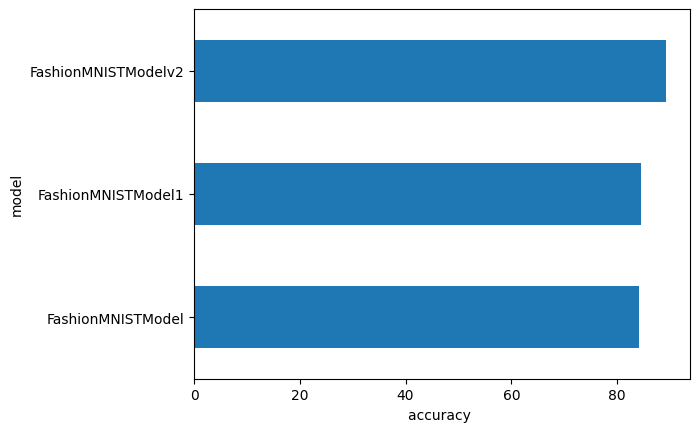

In [49]:
# Visualizing

cmp_results.set_index('model')['acc'].plot(kind='barh')

plt.xlabel('accuracy ')
plt.ylabel('model')

In [50]:
def make_predictions(model : torch.nn.Module, data : list, device : torch.device = device):

    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=1).to(device)
            pred_logits = model(sample)

            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [51]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [52]:
type(test_data)

torchvision.datasets.mnist.FashionMNIST

In [53]:
import random
random.seed(42)

test_samples = []
test_labels = []
for i in range(9):

    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label = test_data[random_idx]
    test_samples.append(img)
    test_labels.append(label)

len(test_samples)

9

In [54]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()